In [2]:
import glob
from functools import reduce
import cartopy.crs as ccrs
import cartopy.feature as cf
import cftime as cf
import geopandas as gp
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import regionmask
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from IPython.display import Markdown
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

# Average impact on the climate 1973-2010:

In [3]:
# Read the output data for the simulation with sector water usage on
output_data_sectorwater_simulation = xr.open_dataset("/glade/work/staranu/paper1_data_simulations/paper1_sectorwater_run.clm2.h1.1971-2010.nc", decode_times=False)
output_data_sectorwater_simulation_surface_variables = xr.open_dataset("/glade/work/staranu/paper1_data_simulations/paper1_sectorwater_run.clm2.h0.1971-2010.nc", decode_times=False)
output_data_control_simulation_surface_variables = xr.open_dataset("/glade/work/staranu/paper1_data_simulations/paper1_control_run.clm2.h0.1971-2010.nc", decode_times=False)

In [4]:
# Prepare for units transformation from mm/year to m3/year
mm_to_m = 10**(-3)
mm_per_s_to_mm_per_day = 86400.0

lnd_area_ctsm_f09_g17 =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/area/area_lnd.nc', decode_times=False)['area'].values.flatten()*(10**6) # transform from km2 to m2
mask_lnd_ctsm_f09_g17 = xr.open_dataset('/glade/u/home/staranu/useful_data/landmask.nc', decode_times=False)['landmask'].values.flatten()
ctsm_f09_g17_mm_per_year_to_km3_per_year_transform = mm_per_s_to_mm_per_day*mm_to_m*lnd_area_ctsm_f09_g17/(10**9)

lon_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LONGXY'].values[0]
lat_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LATIXY'].values[:,0]

In [12]:
# Function to count the number of days from the start of the dataset to the beginning of the analysis period
def count_days_to_start_analysis(start_year, analysis_start_year):
    total_days = 0
    for year in range(start_year, analysis_start_year):
            total_days += 365  # leap years not supported in our simulation
    return total_days

# Count the number of days from January 1, 1971, to January 1, 1973
# Skip first 2 years for spinup purposes
days_to_start_analysis = count_days_to_start_analysis(1971, 1973)

# Update the indices for daily data
mean_dom_cons_1973_2010 = (output_data_sectorwater_simulation["DOM_ACTUAL_CONS"][days_to_start_analysis:].mean(dim="time").values.flatten()*86400*365*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
mean_liv_cons_1973_2010 = (output_data_sectorwater_simulation["LIV_ACTUAL_CONS"][days_to_start_analysis:].mean(dim="time").values.flatten()*86400*365*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
mean_elec_cons_1973_2010 = (output_data_sectorwater_simulation["ELEC_ACTUAL_CONS"][days_to_start_analysis:].mean(dim="time").values.flatten()*86400*365*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
mean_mfc_cons_1973_2010 = (output_data_sectorwater_simulation["MFC_ACTUAL_CONS"][days_to_start_analysis:].mean(dim="time").values.flatten()*86400*365*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
mean_min_cons_1973_2010 = (output_data_sectorwater_simulation["MIN_ACTUAL_CONS"][days_to_start_analysis:].mean(dim="time").values.flatten()*86400*365*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))
total_mean_cons_sectors_except_irrigation_1973_2010 = mean_dom_cons_1973_2010 + mean_liv_cons_1973_2010 + mean_elec_cons_1973_2010 + mean_mfc_cons_1973_2010 + mean_min_cons_1973_2010
mean_irrig_withd_1973_2010 = (output_data_sectorwater_simulation["QIRRIG_FROM_SURFACE"][days_to_start_analysis:].mean(dim="time").values.flatten()*86400*365*mask_lnd_ctsm_f09_g17).reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0]))

# No change needed for monthly data
mean_delta_tg_1973_2010 = (output_data_control_simulation_surface_variables["TG"][12*2:] - output_data_sectorwater_simulation_surface_variables["TG"][12*2:]).mean(dim="time")
mean_delta_tsa_1973_2010 = (output_data_control_simulation_surface_variables["TSA"][12*2:] - output_data_sectorwater_simulation_surface_variables["TSA"][12*2:]).mean(dim="time")
mean_delta_latent_heat_1973_2010 = (output_data_control_simulation_surface_variables["EFLX_LH_TOT"][12*2:] - output_data_sectorwater_simulation_surface_variables["EFLX_LH_TOT"][12*2:]).mean(dim="time")


In [13]:
from sklearn.linear_model import LinearRegression
import numpy as np

actual_withd_irrig = np.array(mean_irrig_withd_1973_2010)
actual_cons_all_sectors_except_irrigation = np.array(total_mean_cons_sectors_except_irrigation_1973_2010)
delta_tg = np.array(mean_delta_tg_1973_2010)
delta_tsa = np.array(mean_delta_tsa_1973_2010)
delta_latent_heat = np.array(mean_delta_latent_heat_1973_2010)

# reshape arrays from (192, 288) to (192*288)
actual_withd_irrig = actual_withd_irrig.reshape(-1, 1)
actual_cons_all_sectors_except_irrigation = actual_cons_all_sectors_except_irrigation.reshape(-1, 1)
delta_tg = np.array(delta_tg).reshape(-1, 1)
delta_tsa = np.array(delta_tsa).reshape(-1, 1)
delta_latent_heat = np.array(delta_latent_heat).reshape(-1, 1)

# Fill NaN values with the mean of the array. You might want to use different strategies for different arrays
# depending on the nature of your data
actual_withd_irrig = np.where(np.isnan(actual_withd_irrig), 0, actual_withd_irrig)
actual_cons_all_sectors_except_irrigation = np.where(np.isnan(actual_cons_all_sectors_except_irrigation), 0, actual_cons_all_sectors_except_irrigation)
delta_tg = np.where(np.isnan(delta_tg), 0, delta_tg)
delta_tsa = np.where(np.isnan(delta_tsa), 0, delta_tsa)
delta_latent_heat = np.where(np.isnan(delta_latent_heat), 0, delta_latent_heat)

# Create a linear regression model
model_based_on_irrig = LinearRegression()
model_based_on_other_sectors = LinearRegression()

# Fit the model with delta_tg
model_based_on_irrig.fit(actual_withd_irrig, delta_tg)
# Get the R^2 value for delta_tg
r2_delta_tg_based_on_irrig = model_based_on_irrig.score(actual_withd_irrig, delta_tg)
# Get the coefficients for delta_tg
coeff_delta_tg_based_on_irrig = model_based_on_irrig.coef_

# Fit the model with delta_tsa
model_based_on_irrig.fit(actual_withd_irrig, delta_tsa)
# Get the R^2 value for delta_tsa
r2_delta_tsa_based_on_irrig = model_based_on_irrig.score(actual_withd_irrig, delta_tsa)
# Get the coefficients for delta_tsa
coeff_delta_tsa_based_on_irrig = model_based_on_irrig.coef_

# Fit the model with delta_latent_heat
model_based_on_irrig.fit(actual_withd_irrig, delta_latent_heat)
# Get the R^2 value for delta_latent_heat
r2_delta_latent_heat_based_on_irrig = model_based_on_irrig.score(actual_withd_irrig, delta_latent_heat)
# Get the coefficients for delta_latent_heat
coeff_delta_latent_heat_based_on_irrig = model_based_on_irrig.coef_

print("These are regression scores using the total irrigation withdrawal")
print('R^2 value for delta_tg:', r2_delta_tg_based_on_irrig)
print('Coefficients for delta_tg:', coeff_delta_tg_based_on_irrig)
print('R^2 value for delta_pot_evap:', r2_delta_tsa_based_on_irrig)
print('Coefficients for delta_pot_evap:', coeff_delta_tsa_based_on_irrig)
print('R^2 value for delta_latent_heat:', r2_delta_latent_heat_based_on_irrig)
print('Coefficients for delta_latent_heat:', coeff_delta_latent_heat_based_on_irrig)
print('_____________________________________________')

# Fit the model with delta_tg
model_based_on_other_sectors.fit(actual_cons_all_sectors_except_irrigation, delta_tg)
# Get the R^2 value for delta_tg
r2_delta_tg_based_on_other_sectors = model_based_on_other_sectors.score(actual_cons_all_sectors_except_irrigation, delta_tg)
# Get the coefficients for delta_tg
coeff_delta_tg_based_on_other_sectors = model_based_on_other_sectors.coef_

# Fit the model with delta_tsa
model_based_on_other_sectors.fit(actual_cons_all_sectors_except_irrigation, delta_tsa)
# Get the R^2 value for delta_tsa
r2_delta_tsa_based_on_other_sectors = model_based_on_other_sectors.score(actual_cons_all_sectors_except_irrigation, delta_tsa)
# Get the coefficients for delta_tsa
coeff_delta_tsa_based_on_other_sectors = model_based_on_other_sectors.coef_

# Fit the model with delta_latent_heat
model_based_on_other_sectors.fit(actual_cons_all_sectors_except_irrigation, delta_latent_heat)
# Get the R^2 value for delta_latent_heat
r2_delta_latent_heat_based_on_other_sectors = model_based_on_other_sectors.score(actual_cons_all_sectors_except_irrigation, delta_latent_heat)
# Get the coefficients for delta_latent_heat
coeff_delta_latent_heat_based_on_other_sectors = model_based_on_other_sectors.coef_

print("These are regression scores using the total consumption from all the sectors except irrigation")
print('R^2 value for delta_tg:', r2_delta_tg_based_on_other_sectors)
print('Coefficients for delta_tg:', coeff_delta_tg_based_on_other_sectors)
print('R^2 value for delta_pot_evap:', r2_delta_tsa_based_on_other_sectors)
print('Coefficients for delta_pot_evap:', coeff_delta_tsa_based_on_other_sectors)
print('R^2 value for delta_latent_heat:', r2_delta_latent_heat_based_on_other_sectors)
print('Coefficients for delta_latent_heat:', coeff_delta_latent_heat_based_on_other_sectors)




These are regression scores using the total irrigation withdrawal
R^2 value for delta_tg: 0.9044530311095236
Coefficients for delta_tg: [[0.00239991]]
R^2 value for delta_pot_evap: 0.8653404442755317
Coefficients for delta_pot_evap: [[0.00053893]]
R^2 value for delta_latent_heat: 0.9123306824273753
Coefficients for delta_latent_heat: [[-0.05622971]]
_____________________________________________
These are regression scores using the total consumption from all the sectors except irrigation
R^2 value for delta_tg: 0.07618659385134818
Coefficients for delta_tg: [[0.00384033]]
R^2 value for delta_pot_evap: 0.06536762921268235
Coefficients for delta_pot_evap: [[0.00081667]]
R^2 value for delta_latent_heat: 0.07290034707848314
Coefficients for delta_latent_heat: [[-0.08763573]]


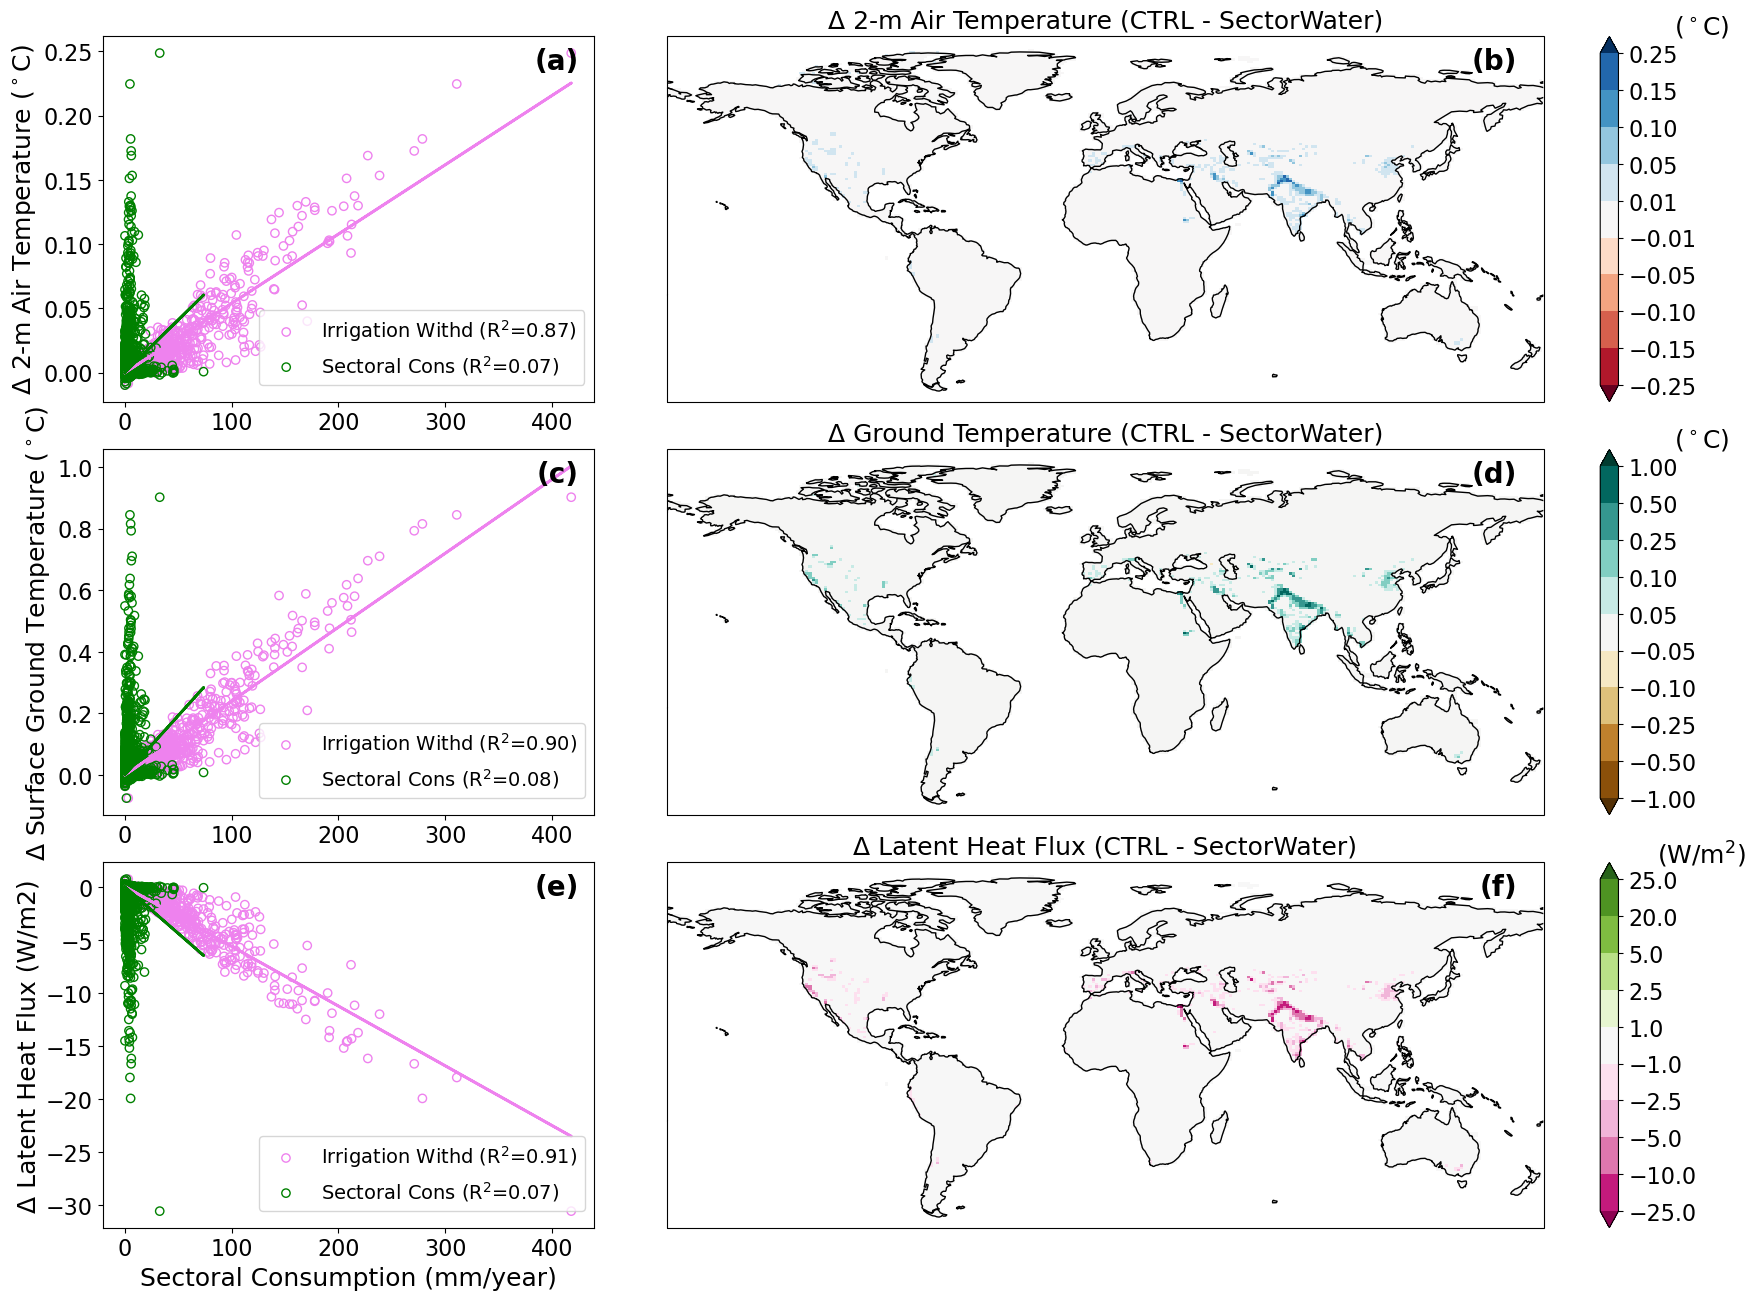

In [14]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import matplotlib as mpl

# Create a linear regression model
model_based_on_irrig = LinearRegression()
model_based_on_other_sectors = LinearRegression()

# List of variables and their names
variables = [(delta_tsa,  u'\u0394'+ ' 2-m Air Temperature' + ' ($^\circ$C)'), 
             (delta_tg, u'\u0394'+ ' Surface Ground Temperature' + ' ($^\circ$C)'), 
             (delta_latent_heat, u'\u0394'+ ' Latent Heat Flux' + ' (W/m2)')]
models = [(model_based_on_irrig, actual_withd_irrig, 'Irrigation Withd', 'violet'),
          (model_based_on_other_sectors, actual_cons_all_sectors_except_irrigation, 'Sectoral Cons', 'green')]
# Define settings for each plot
plot_settings = [
    {"cmap": plt.cm.RdBu, "bounds": [-0.25, -0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15, 0.25], "label": u'\u0394'+' 2-m Air Temperature (CTRL - SectorWater)', "unit": '($^\circ$C)'},
    {"cmap": plt.cm.BrBG, "bounds": [-1.0, -0.5, -0.25, -0.1, -0.05, 0.05, 0.1, 0.25, 0.5, 1.0], "label": u'\u0394'+' Ground Temperature (CTRL - SectorWater)', "unit": '($^\circ$C)'},
    {"cmap": plt.cm.PiYG, "bounds": [-25, -10, -5, -2.5, -1, 1, 2.5, 5, 20, 25], "label": u'\u0394'+' Latent Heat Flux (CTRL - SectorWater)', "unit": '(W/m$^2$)'}
]

data_vars = [mean_delta_tsa_1973_2010, mean_delta_tg_1973_2010, mean_delta_latent_heat_1973_2010]

projection = ccrs.PlateCarree()  # Change the projection to the default one

def plot_background(ax, crs):
    ax.coastlines()
    return ax

fig = plt.figure(figsize=(18, 13.1))
gs = gridspec.GridSpec(3, 2, width_ratios=[0.65, 1.5], height_ratios=[1, 1, 1])  # Define the grid of plots

subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']  # Labels for each subplot
label_font_size = 18  # Font size for labels
tick_font_size = 16   # Font size for ticks
title_font_size = 18  # Font size for title

# Loop over each variable
for i, (delta, var_name) in enumerate(variables):
    ax1 = plt.subplot(gs[i, 0])  # Create subplot for scatter plot
    ax2 = plt.subplot(gs[i, 1], projection=projection)  # Create subplot for map plot

    legend_labels = []  # List to store legend labels with R^2 values

    # Loop over each model for scatter plots
    for j, (model, X, label, color) in enumerate(models):
        # Fit the model with delta
        model.fit(X, delta)
        # Get the R^2 value for delta
        r2 = model.score(X, delta)
        legend_labels.append(f'{label} (R$^2$={r2:.2f})')  # Add legend label with R^2 value
        # Predict y for regression line
        y_pred = model.predict(X)
        # Scatter plot of X vs delta
        ax1.scatter(X, delta, color=color, facecolors='none', label=legend_labels[j])
        # Regression line
        ax1.plot(X, y_pred, color=color, linewidth=2)
        
    # Set labels and ticks for scatter plots
    if i == 2:
        ax1.set_xlabel('Sectoral Consumption (mm/year)', fontsize=label_font_size)
    ax1.set_ylabel(var_name, fontsize=label_font_size)
    ax1.tick_params(labelsize=tick_font_size)  # Increase ticks and labels size for first column plots
    ax1.legend(loc='lower center', bbox_to_anchor=(0.65, 0.02), fontsize=14)
    # Plot the map
    plot_background(ax2, projection)
    ax2.set_extent([-180, 180, -60, 90], crs=projection)  # Cut out the Antarctica
    data_var = data_vars[i]
    settings = plot_settings[i]
    masked_data = data_var
    norm = mpl.colors.BoundaryNorm(settings["bounds"], settings["cmap"].N, extend='both')
    pcol = ax2.pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, masked_data, cmap=settings["cmap"], norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
    ax2.set_title(settings["label"], fontsize=title_font_size)
    cbar = fig.colorbar(pcol, ax=ax2, orientation='vertical', pad=0.05, ticks=settings["bounds"])
    cbar.set_label(settings["unit"], size=label_font_size, rotation=0, y=1.12)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    # Add subplot labels to both scatter plot (ax1) and map plot (ax2)
    ax1.text(0.97, 0.97, subplot_labels[2*i], transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')
    ax2.text(0.97, 0.97, subplot_labels[2*i + 1], transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig("Results/png_format/Climate_impact.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()


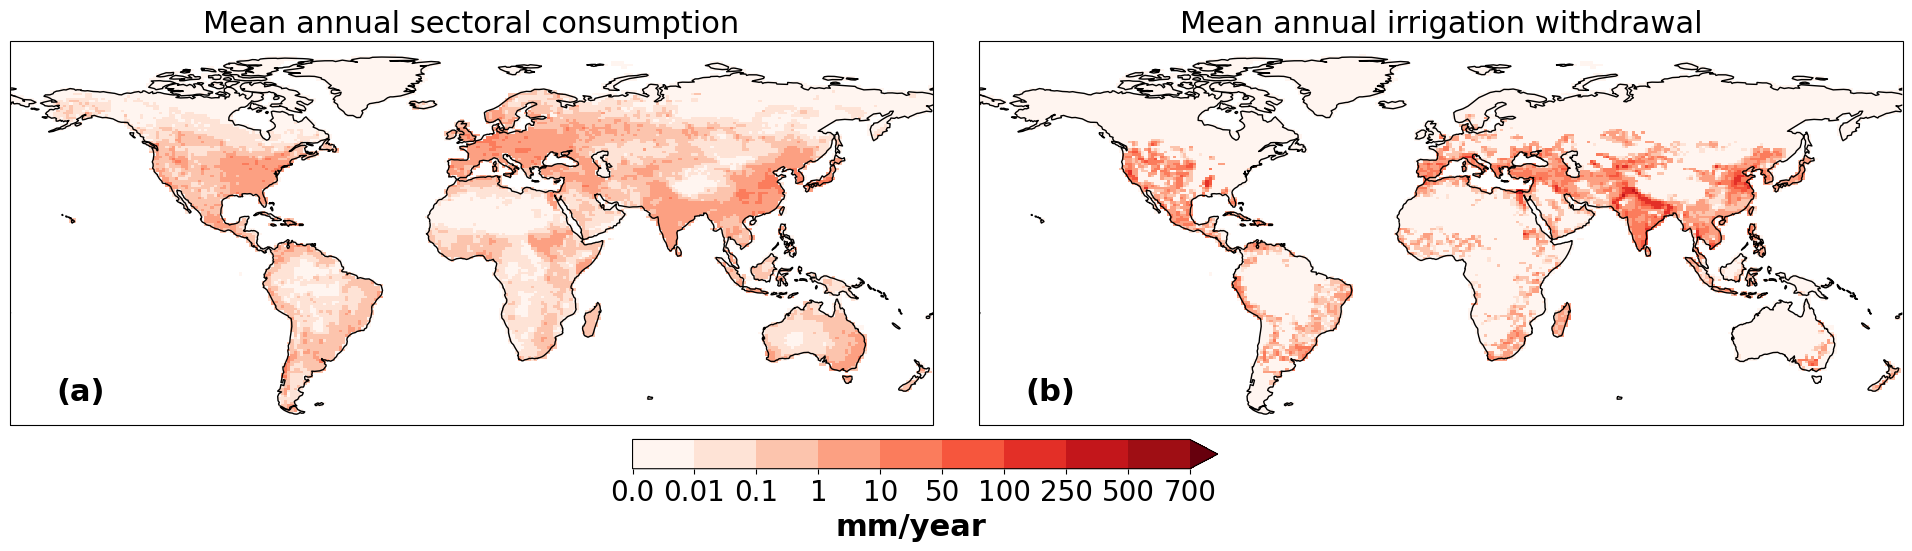

In [15]:
# Create the subplots
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(6.6*3.7, 3.8*2), constrained_layout=False, subplot_kw={'projection': projection})
axlist = axarr.flatten()

# Adjust extent and plot background
for ax in axlist:
    ax.set_extent([-180, 180, -60, 90], crs=projection)
    plot_background(ax, projection)

# Set color map and normalization boundaries
cmap = plt.cm.Reds
bounds = [0.0, 0.01, 0.1, 1, 10, 50, 100, 250, 500, 700]
ticks = [0.0, 0.01, 0.1, 1, 10, 50, 100, 250, 500, 700]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')

# Plot the maps and set titles
labels = ['(a)', '(b)']  # Labels for the subplots
for ax, data, title, label in zip(axlist, [total_mean_cons_sectors_except_irrigation_1973_2010, mean_irrig_withd_1973_2010], ['Mean annual sectoral consumption', 'Mean annual irrigation withdrawal'], labels):
    # Mask the data for Greenland
    masked_data = data  # Use this line for now since we don't have the actual Greenland mask
    
    map = ax.pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17, masked_data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), rasterized=True)
    ax.set_title(title, fontsize=22)
    ax.text(0.05, 0.05, label, transform=ax.transAxes, fontsize=22, fontweight='bold', va='bottom', ha='left')

plt.subplots_adjust(wspace=0.05, hspace=0.1)

ticks_labels = ['{:.2f}'.format(val) if val == 0.01 else str(val) for val in bounds]
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axarr, orientation='horizontal', ticks=ticks, fraction=0.05, pad=0.024, shrink=1)
cb.set_label('mm/year', size=22, weight='bold', rotation=0, y=1.05)
cb.ax.tick_params(labelsize=20)
cb.ax.set_xticklabels(ticks_labels)

plt.savefig("Results/png_format/Map_total_mean_cons_and_irrig_withdrawal_1973_2010.png", format='png', edgecolor='none', dpi=600, bbox_inches='tight', pad_inches=0.5)
plt.show()
